In [9]:
import splat
import wisps
import matplotlib.pyplot as plt
from wisps.data_analysis import selection_criteria as sel_crt
from wisps.simulations import selection_function as slf
import numpy as np
import pandas as pd

import numba
import matplotlib as mpl
mpl.rcParams['font.size'] = 18

#read in the data 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from google.colab import drive #to import my own module, I must first follow this procedure:
from itertools import combinations
#%%capture  output
import itertools
from tqdm import tqdm
import keras

import seaborn as sns 
cmap=sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
from matplotlib.ticker import MultipleLocator
import tensorflow
#read in the data 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from google.colab import drive #to import my own module, I must first follow this procedure:
from itertools import combinations
%tensorflow_version 2.x
import kerastuner as kt
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow.keras.metrics as k_metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.metrics as k_metrics
from keras import optimizers
import IPython
from scipy import stats

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
%matplotlib inline

In [3]:
#read in some data
sf=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl') #the simulated spectral data

In [20]:
#selection objects 
rfdict=pd.read_pickle(wisps.OUTPUT_FILES+'/random_forest_classifier.pkl') #the classifier 
indices_to_use= pd.read_pickle(wisps.OUTPUT_FILES+'/best_indices_to_use.pkl')
neural_network= keras.models.load_model(wisps.OUTPUT_FILES+'/model_loss_weighted_with_galax_sptft.h5')

In [21]:
#some formatting
sampled_data=pd.DataFrame.from_records(pd.DataFrame(sf).values.flatten())
sampled_data['sp_old']=np.vstack(sampled_data.sp_old.values)[:,0]
sampled_data['spt_new']=np.vstack(sampled_data.spt_new.values)[:,0]

In [22]:
#things that missed their classification 
sampled_data['missed_label']=sampled_data['sp_old'].apply(wisps.make_spt_number) != sampled_data['spt_new'].apply(wisps.make_spt_number)
sampled_data['missed_label']=1-sampled_data.missed_label.apply(int).apply(float)
sampled_data['Names']=['spctr'+ str(idx) for idx in sampled_data.index]
sampled_data['spt']=sampled_data['sp_old'].apply(wisps.make_spt_number)

In [23]:
#selection criteria
slc_crts=sel_crt.crts_from_file()

#### Define a bunch of selection processes

In [24]:
#define a number of selectors 
#each selection should a column of zeros and ones corresponding
#to where objects were selected
#each selector input is the simulated df

def select_by_indices(df):
    #use spectral indices
    good_indices=[slc_crts[k] for k in indices_to_use.keys()]
    cands=[]
    
    for idx, k in zip(good_indices, indices_to_use.keys()):
        spt_range=indices_to_use[k]
        bs=idx.shapes
        bx=[x for x in bs if x.shape_name==spt_range][0]
        df_to_use=wisps.Annotator.reformat_table(df[[idx.xkey, idx.ykey]]).reset_index(drop=True)
        
        sel, bools= bx._select(np.array([df_to_use.values[:,0], df_to_use.values[:, 1]]))
    
        classifics=df.spt_new.apply(lambda x: wisps.is_in_that_classification(x, spt_range) ).values
        
        df['selected_by_{}'.format(spt_range)]=False
        df['selected_by_{}'.format(spt_range)]=(classifics & bools)
        
        

def select_by_f_test(df):
    df['f_test_label']=False
    bools=(df.f_test <.4).values
    df.loc[bools, 'f_test_label']=True
    

def apply_scale(x):
    ##remove nans 
    ##this is the same scaling used 
    ## same scaling used for 
    #replace nans
    y=x
    if np.isnan(y) or np.isinf(y) or abs(y) > 1e10:
        y=-99
    return y


def select_by_random_forest(df):
    #use the classification given by my rf classifier
    
    rf=rfdict['classifier']
    #min_max_scaler=rfdict['sclr']
    features=rfdict['feats']
    
    #apply logs to problematic features the same way I did on my classification
    df[features]=df[features].applymap(apply_scale)
    
    #make predictions
    probs=rf.predict_proba(df[features].values)
    
    #use my selection probability cutoffs
    #return the predictions
    labels=np.logical_or.reduce((probs[:, 2] > .7, probs[:,3] >.7 , probs[:,4] >0.7))
 
    return labels



def select_by_neuralnet(df):
    features=['H_2O-1/J-Cont', 'H_2O-2/H_2O-1', 'H-cont/H_2O-1', 'CH_4/H_2O-1',
       'H_2O-2/J-Cont', 'H-cont/J-Cont', 'CH_4/J-Cont', 'H-cont/H_2O-2',
       'CH_4/H_2O-2', 'CH_4/H-Cont', 'H_2O-1+H_2O-2/J-Cont',
      'H_2O-1+H_2O-2/H-Cont', 'H_2O-1+CH_4/J-Cont', 'H_2O-2+CH_4/J-Cont',
      'H_2O-1+CH_4/H-Cont', 'H_2O-2+CH_4/H-Cont', 'spt', 'f_test']
    
    #apply logs to problematic features the same way I did on my classification
    pred_set=df[features]
    
    for c in features:
        if c not in ['spt', 'f_test']:
              pred_set[c]=np.log10(  pred_set[c])
       

    pred_set[features]=  pred_set[features].applymap(apply_scale)
    probs= neural_network.predict(  pred_set[features].values)
    
    #my cuts
    labels=np.logical_or.reduce((probs[:, 3] > .97, probs[:,2] >.9 , probs[:,4] >0.9))
    #labels=probs[:,0] <0.5
 
    return labels


In [25]:
df=sampled_data

In [26]:
#machine learning
df['rf_label']=select_by_random_forest(wisps.Annotator.reformat_table(df))
df['neural_net_label']=select_by_neuralnet(wisps.Annotator.reformat_table(df))

df['rf_label']=(df['rf_label'].apply(bool) ).apply(int)
df['neural_net_label']=(df['neural_net_label'].apply(bool) ).apply(int)

In [43]:
#indices

select_by_f_test(df)
select_by_indices(df)

In [44]:
#indices and total
df.f_test_label=(df['f_test_label']).apply(int)

df['index_label']=np.logical_or.reduce([df['selected_by_{}'.format(x)].values for x in  indices_to_use.values()])
df['idx_ft_label']=np.logical_and(df['index_label'].apply(bool), df['f_test_label'].apply(bool) ).apply(int)


df['tot_label']=np.logical_or.reduce((df['idx_ft_label'].apply(bool), df['rf_label'].apply(bool), df['neural_net_label'].apply(bool)))
df.tot_label=df.tot_label.apply(int)

#put things on log-scale
df['logsnr']=df['snr1'].apply(np.log10)

In [45]:
#df2['idx_ft_label']=df2[['spt', 'snr']].apply(probability_of_selection, axis=1, method='idx_ft_label')

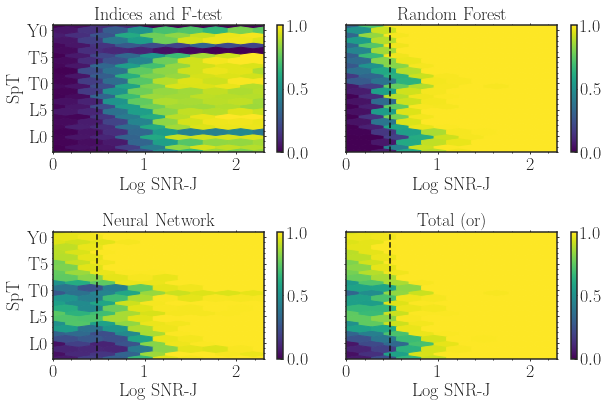

In [59]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(6*1.5, 4*1.5), sharex=False, sharey=True)
df.plot.hexbin(x='logsnr', y='spt', C='idx_ft_label', reduce_C_function=np.nanmean, gridsize=25, cmap='viridis', ax=ax[0][0])
df.plot.hexbin(x='logsnr', y='spt', C='rf_label', reduce_C_function=np.nanmean, gridsize=25, cmap='viridis', ax=ax[0][1])
df.plot.hexbin(x='logsnr', y='spt', C='neural_net_label', reduce_C_function=np.nanmean, gridsize=25, cmap='viridis', ax=ax[1][0])
df.plot.hexbin(x='logsnr', y='spt', C='tot_label', reduce_C_function=np.nanmean, gridsize=25, cmap='viridis', ax=ax[1][1])

#ax[0][0].scatter( sf.data.snr1.apply(np.log10), sf.data.spt, marker='+', color='#111111', alpha=.05)


ax[0][0].set_title('Indices and F-test', fontsize=18)
ax[0][1].set_title('Random Forest', fontsize=18)
ax[1][0].set_title('Neural Network', fontsize=18)
ax[1][1].set_title('Total (or)', fontsize=18)

for a in np.concatenate(ax):
    a.set_xlabel('Log SNR-J', fontsize=18)
    a.set_ylabel('SpT', fontsize=18)
    a.axvline(np.log10(3), linestyle='--', color='#111111')
    

    a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor',direction='inout')
    
    a.minorticks_on()
    a.set_yticks(np.arange(17, 41),  minor=True)
    a.set_yticks([20, 25, 30, 35, 40], minor=False)
    a.set_yticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'], minor=False)
    a.set_xlim([0., 2.3])
    a.set_ylim([17., 41.])
    
plt.tight_layout()


plt.savefig(wisps.OUTPUT_FIGURES+'/selection_function_samples.pdf', bbox_inches='tight', dpi=200)

In [47]:
#save partial of the data to use for my selection function calculations
df2=(df[['logsnr', 'tot_label', 'spt']])

In [48]:
df2.shape

(48300, 3)

In [49]:
df2.to_pickle(wisps.OUTPUT_FILES+'/selection_function_lookup_table.pkl')

In [50]:
cands=pd.read_pickle(wisps.OUTPUT_FILES+'/true_spectra_cands.pkl')
obsfs=cands.spectra.apply(lambda x: x.f_test)
obsnsr=cands.spectra.apply(lambda x: x.snr['snr1'])

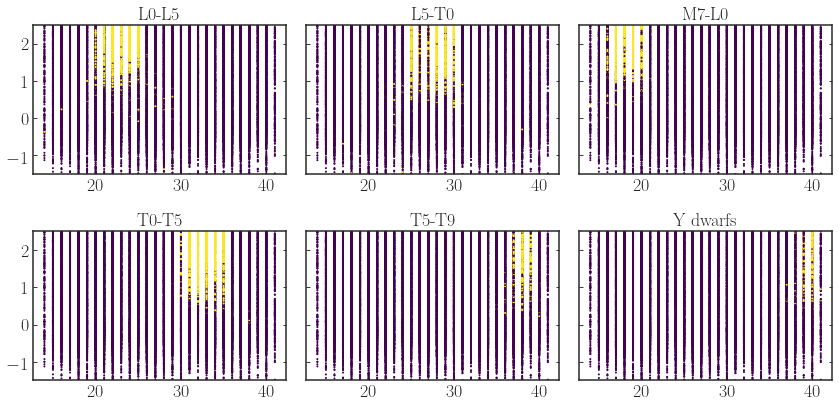

In [51]:
fig, ax=plt.subplots(ncols=3, nrows=2, figsize=(8*1.5, 4*1.5), sharex=False, sharey=True)

for a, grp in zip(np.concatenate(ax), indices_to_use.values() ):
    c=a.scatter(df.spt, df.logsnr, c=df['selected_by_{}'.format(grp)], s=1., cmap='viridis')
    
    a.set_title(grp, fontsize=18)

    #a.set_xlabel('Log SNR-J', fontsize=18)
    #a.set_ylabel('SpT', fontsize=18)
    a.set_ylim([-1.5, 2.5])

#plt.colorbar(c)
    
plt.tight_layout()

In [52]:
spex=wisps.datasets['spex']
spex=wisps.Annotator.reformat_table(spex)

In [53]:
inv_indices_to_use={v: k for k, v in indices_to_use.items()}

In [54]:
inv_indices_to_use

{'L0-L5': 'H_2O-1/J-Cont CH_4/H-Cont',
 'L5-T0': 'CH_4/H_2O-2 H_2O-2+CH_4/J-Cont',
 'M7-L0': 'CH_4/H-Cont H_2O-1+H_2O-2/J-Cont',
 'T0-T5': 'CH_4/H_2O-2 H_2O-1+H_2O-2/J-Cont',
 'T5-T9': 'H-cont/H_2O-1 H_2O-1+CH_4/H-Cont',
 'Y dwarfs': 'H_2O-1/J-Cont H_2O-1+CH_4/H-Cont',
 'subdwarfs': 'H_2O-1/J-Cont H-cont/J-Cont'}

In [55]:
df=wisps.Annotator.reformat_table(df)

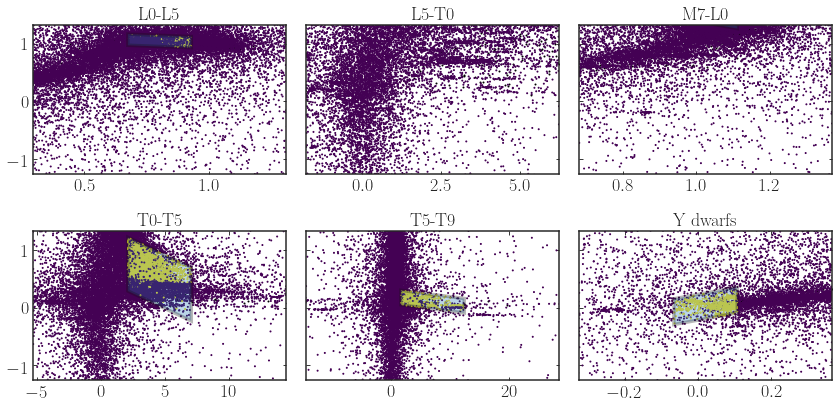

In [56]:
fig, ax=plt.subplots(ncols=3, nrows=2, figsize=(8*1.5, 4*1.5), sharex=False, sharey=True)

for a, grp in zip(np.concatenate(ax), indices_to_use.values() ):
    
    bx=None
    bs=None

    idx_label=inv_indices_to_use[grp]
    
    idx=slc_crts[idx_label]
    
    bs=idx.shapes
    bx=[x for x in bs if x.shape_name==grp][0]
    
   
    c=a.scatter(spex[idx.xkey], spex[idx.ykey], s=1., c='k')
    c=a.scatter(df[idx.xkey], df[idx.ykey], c=df['selected_by_{}'.format(grp)], s=1., cmap='viridis')
    
    bx.plot(ax=a,  only_shape=True, highlight=True)
    
    a.set_title(grp, fontsize=18)

    a.set_xlim([ bx.xrange[0]-1.5*abs(np.ptp(bx.xrange)), bx.xrange[1]+1.5*abs(np.ptp(bx.xrange))])
    a.set_ylim([ bx.yrange[0]-1.5*abs(np.ptp(bx.yrange)), bx.yrange[1]+1.5*abs(np.ptp(bx.yrange))])

    #a.set_xlabel('Log SNR-J', fontsize=18)


#plt.colorbar(c)
    
plt.tight_layout()